In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.manifold import TSNE
data = pickle.load(open('/data/deephawkes/citation1/ana.pkl','rb'))
# data = pickle.load(open('/data/deephawkes/weibo1/ana.pkl','rb'))
data.keys()

dict_keys(['Xtest', 'Ytest', 'hidden_states', 'hidden_states_decay', 'time', 'emb'])

In [2]:
def invisible(ax):
    # ax=plt.gca()  #gca:get current axis得到当前轴
    #设置图片的右边框和上边框为不显示
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.axes.get_yaxis().set_visible(False)
    # x 轴不可见
    ax.axes.get_xaxis().set_visible(False)

In [3]:
Ytest = np.array(data['Ytest'])
Xtest = np.array(data['Xtest'])
time = data['time']
emb = data['emb'][0]
# Ytest = np.power(2,Ytest)
Hs = np.array(data['hidden_states_decay'])
len(Ytest),Hs.shape
print(len(Hs[0][0]), len(Xtest[0]),len(time))
print(emb.shape)

13 13 13108
(203539, 50)


/home/ta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/ta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [4]:
idmap = pickle.load(open('/data/deephawkes/citation1/'+"idmap.pkl", 'rb'))
idmapf={}
for index,true in enumerate(idmap):
    idmapf[str(true)]=emb[index]

In [5]:
from tqdm import tqdm
import time


# print(os.getcwd())


def get_hour(time_str, filename):
    hour = None
    try:
        msg_time = int(time_str)
        hour = time.strftime("%H", time.localtime(msg_time))
        hour = int(hour)
    except:
        if '170w' in filename:  # fixed in 11.15, however, in this way, more datasets will be removed
            ts = time.strptime(time_str, '%Y-%m-%d-%H:%M:%S')
            hour = ts.tm_hour
        elif 'castle' in filename:
            # for data castle weibo
            hour = int(time_str[:2])
        elif 'smp' in filename:
            ts = time.strptime(time_str, '%Y-%m-%dT%H:%M:%S')
            hour = ts.tm_hour
        else:
            print(time_str)
            print('wrong time format')
    return hour
import networkx as nx
def construct_G(filename='/home/ta/yh/open-cas/rawdata/dataset_weibo.txt'):
    G = nx.Graph()
    cascade_count={}
    # filename='./dataset_citation.txt'
    discard_midnight = 0
    discard_outer = 0       
    file = open(filename)
    cascades_total = dict()
    year_grow = dict()
    num_lines = sum(1 for line in open(filename, 'r'))
    for line in tqdm(file, total=num_lines):
        parts = line.strip().split("\t")
        if len(parts) != 5:
            print('wrong format!')
            continue
        cascadeID = parts[0]
        # print cascadeID
        n_nodes = int(parts[3])

        path = parts[4].split(" ")
        if n_nodes != len(path):
            print(cascadeID,' wrong number of nodes', n_nodes, len(path),path)
            exit(0)
        # for p in path:
        #     nodes = p.split(":")[0].split("/")
        #     time_ = int(int(p.split(":")[1]))
        #     if time_<=3600:
        #         num+=1
        # if num>100 :
        #     discard_outer+=1
        #     continue
        # if n_nodes<5 or n_nodes>100:
        #     continue
        hour = get_hour(parts[2], filename)
        # to keep the same with
        if hour <= 7 or hour >= 19:  # 8-18
            discard_midnight += 1
            continue
        observation_path = []
        # print(cascadeID)
        for p in path:
            nodes = p.split(":")[0].split("/")
            time_ = int(int(p.split(":")[1])/360)
            try:
                year_grow[time_]+=1
            except:
                year_grow[time_]=1
            nodes_ok = True
            for n in nodes:
                if int(n) == -1:  # delete invalid id
                    nodes_ok = False
            if not (nodes_ok):
                print("error id at cas_id {}".format(cascadeID))
                print(nodes)
                continue
            # print nodes
            time_now = int(p.split(":")[1])

            observation_path.append(",".join(nodes) + ":" + str(time_now))
            for i in range(1, len(nodes)):
                G.add_edge(nodes[i - 1] , nodes[i])
        # if len(observation_path)<5 or  len(observation_path) > 1000:
        #     # least_rewteetnum = opts.least_num   # 5 or 10
        #     # if len(observation_path) < least_rewteetnum:
            
        #     discard_outer += 1
        #     continue


        # if labels[0]>1000:
        #     continue


        # try:
        #     cascades_total[cascadeID] = msg_time
        # except:
        cascades_total[cascadeID] = hour

    n_total = len(cascades_total)
    print("total_readin:", num_lines)
    print("discard_midnight:", discard_midnight)
    print("discard_outer:", discard_outer)
    print('total:', n_total)
    # import operator
    # sorted_msg_time = sorted(cascades_total.items(),
    #                          key=operator.itemgetter(1))
    # 计算每个节点的 PR 值，并作为节点的 pagerank 属性
    print('computing pange rank')
    pagerank = nx.pagerank(G)
    # 将 pagerank 数值作为节点的属性
    nx.set_node_attributes(G, name = 'pagerank', values=pagerank)
    print('computing done')

    return G
    # 划分数据集
G = construct_G('/home/ta/yh/open-cas/rawdata/dataset_citation.txt')
page_rank = nx.get_node_attributes(G, "pagerank")
# page_rank['1130594']

100%|██████████| 72936/72936 [00:17<00:00, 4222.27it/s]


total_readin: 72936
discard_midnight: 0
discard_outer: 0
total: 72936
computing pange rank
computing done


In [6]:
X = []
y = []
for k,v in idmapf.items():
    if k=='-1':
        continue
    X.append(v)
    y.append(page_rank[k])
X=np.array(X)
y=np.array(y)

In [8]:
avg = np.average(y)
top = sorted(y,reverse=True)[int(len(y)*0.01)]
sample = int(len(y)*0.01)
print(sample)
print(avg)
label = []
new_X = []
for i,x in zip(y,X):
    if i>top:
        label.append(2)
        new_X.append(x)
    # elif i > avg*0.9:
    #     label.append(1)
    elif sample > 0:
        sample-=1
        label.append(0)
        new_X.append(x)
# X label
label=np.array(label)
np.sum(label==0),np.sum(label==1),np.sum(label==2)

2035
3.726206072412519e-06


(2035, 0, 2035)

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(new_X, label,test_size=0.25, stratify = label)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf.predict_proba(X_test)
clf.predict(X_test)
mlp_predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, mlp_predictions)
acc = clf.score(X_test, y_test)
print(acc,cm)

0.4823182711198428 [[229 280]
 [247 262]]


/home/ta/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [15]:
current_graph_size = []
graph_repre = []
for h in Hs:
    h = h[0]
    cur_size = 1
    for hi in h:
        current_graph_size.append(cur_size)
        cur_size+=1
        graph_repre.append(hi)

In [16]:
np.max(current_graph_size)

100

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 80000 samples in 7.032s...
[t-SNE] Computed neighbors for 80000 samples in 551.869s...
[t-SNE] Computed conditional probabilities for sample 1000 / 80000
[t-SNE] Computed conditional probabilities for sample 2000 / 80000
[t-SNE] Computed conditional probabilities for sample 3000 / 80000
[t-SNE] Computed conditional probabilities for sample 4000 / 80000
[t-SNE] Computed conditional probabilities for sample 5000 / 80000
[t-SNE] Computed conditional probabilities for sample 6000 / 80000
[t-SNE] Computed conditional probabilities for sample 7000 / 80000
[t-SNE] Computed conditional probabilities for sample 8000 / 80000
[t-SNE] Computed conditional probabilities for sample 9000 / 80000
[t-SNE] Computed conditional probabilities for sample 10000 / 80000
[t-SNE] Computed conditional probabilities for sample 11000 / 80000
[t-SNE] Computed conditional probabilities for sample 12000 / 80000
[t-SNE] Computed conditional probabilities for s

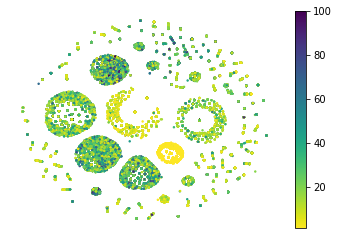

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
plt.close()
invisible(plt.gca())
dHs,dIs = shuffle(graph_repre,current_graph_size)
# print(len(dHs))
X = TSNE(n_components=2,random_state=42,verbose=1).fit_transform(dHs[:80000])
sc = plt.scatter(X[:, 0], X[:, 1],s=2, c=dIs[:80000], cmap='viridis_r')
plt.colorbar(sc)
plt.savefig('graph_size.png',dpi=600)

In [6]:
cascade_features = []
for cas in Hs:
    cas = cas[0]
    cascade_features.append(np.sum(cas,axis=0))
cascade_features = np.array(cascade_features)
cascade_features.shape



(15956, 64)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.376s...
[t-SNE] Computed neighbors for 10000 samples in 22.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.004541
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.115959
[t-SNE] KL divergence after 1000 iterations: 1.047743


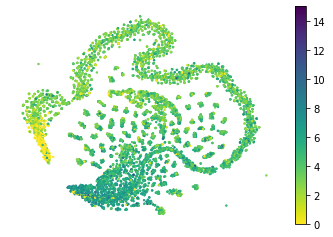

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
plt.close()
invisible(plt.gca())
dHs,dIs = shuffle(cascade_features,Ytest)
X = TSNE(n_components=2,random_state=42,verbose=1).fit_transform(dHs[:10000])
sc = plt.scatter(X[:, 0], X[:, 1],s=2, c=dIs[:10000], cmap='viridis_r')
plt.colorbar(sc)
plt.savefig('future_growth.png',dpi=600)

In [18]:
Hs.shape,Hs[1][0].shape

((15956, 1), (41, 64))

In [19]:
ob_time = 3600
interval = 180
hiddens  = []
graph_size = []
for hs,ts in zip(Hs,time):
    hidden_g = []
    size_g = []
    for time_interval in range(180,3600+1,180):
        size = 0
        for idx,t in enumerate(ts):
            
            if t<time_interval :
                size+=1
            elif t>=time_interval:
                hidden_g.append(hs[0][idx-1])
                size_g.append(size)
                break
            if idx==len(ts)-1:
                hidden_g.append(hs[0][idx])
                size_g.append(size)
                break
    hiddens.append(hidden_g)
    graph_size.append(size_g)

            
print(len(hiddens[0]))




20


In [20]:
len(time[0])

18

In [21]:
graph_size[44]

[2, 6, 8, 11, 13, 16, 18, 20, 22, 23, 23, 26, 26, 27, 29, 29, 29, 29, 31, 31]

In [22]:
hiddens = np.array(hiddens)
graph_size = np.array(graph_size)
print(hiddens.shape,graph_size.shape)

(15956, 20, 64) (15956, 20)


In [23]:
from sklearn.utils import shuffle

diff_inc,diff_hidden,hist_hidden = [],[],[]
for inc,rnn_hidden in zip(graph_size,hiddens):
    diff_inc.append(inc[1:]-inc[:-1])
    hist_hidden.append(rnn_hidden[:-1])
    diff_hidden.append(rnn_hidden[1:]-rnn_hidden[:-1])
diff_inc=np.array(diff_inc).reshape(-1)
hist_hidden=np.array(hist_hidden).reshape(-1,64)
diff_hidden=np.array(diff_hidden).reshape(-1,64)
print(diff_inc.shape,hist_hidden.shape,diff_hidden.shape)
diff_hidden,diff_inc,hist_hidden=shuffle(diff_hidden,diff_inc,hist_hidden)

(303164,) (303164, 64) (303164, 64)


In [27]:
dHs,dIs = [],[]
az = 0
for h,i in zip(diff_hidden,diff_inc):
    if i <2:
        continue
    if h.all()==0:
        az+=1
        continue
    dHs.append(h)
    dIs.append(np.log2(i))
dHs = np.array(dHs)
dIs = np.array(dIs)
print(len(dHs))
print(az)

38112
28554


In [28]:
np.max(dIs)

6.614709844115208

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.106s...
[t-SNE] Computed neighbors for 10000 samples in 12.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.354538
[t-SNE] KL divergence after 1000 iterations: 0.991230


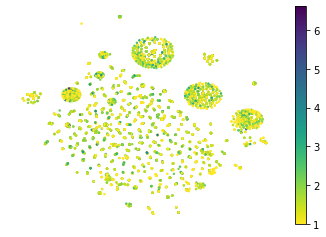

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.close()
invisible(plt.gca())
dHs,dIs = shuffle(dHs,dIs)
X = TSNE(n_components=2,random_state=42,verbose=1).fit_transform(dHs[:10000])
sc = plt.scatter(X[:, 0], X[:, 1],s=2, c=dIs[:10000], cmap='viridis_r')
plt.colorbar(sc)
plt.savefig('diff.png',dpi=600)

In [30]:
embs = np.array(data['emb'][0])
embs.shape

(752556, 50)